Draft to measure emmsion lines. Make model line, convolve model by appropriate lsf, fit to spectrum.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [5]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'

In [6]:
hdul = fits.open('{}hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits'.format(path))

In [7]:
data = hdul[1].data
inst_list = hdul[2].data
inst_list

FITS_rec([( 65536, 'MOD', 'LYA', 'YOUNG', 'hlsp_muscles_mod_lya_gj15a_young_v1_component-spec.fits'),
          (    16, 'HST', 'STS', 'E140M', 'hlsp_muscles_hst_sts_gj15a_e140m_v1_component-spec.fits'),
          (524288, 'HST', 'STS', 'G230LB', 'hlsp_muscles_hst_sts_gj15a_g230lb_v1_component-spec.fits'),
          (131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj15a_na_v1_component-spec.fits'),
          (   256, 'HST', 'STS', 'G430L', 'hlsp_muscles_hst_sts_gj15a_g430l_v1_component-spec.fits'),
          (131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj15a_na_v1_component-spec.fits'),
          (  8192, 'CXO', 'ACS', 'NA', 'hlsp_muscles_cxo_acs_gj15a_na_v1_component-spec.fits'),
          ( 32768, 'MOD', 'APC', 'NA', 'hlsp_muscles_mod_apc_gj15a_na_v1_component-spec.fits'),
          ( 16384, 'MOD', 'EUV', 'YOUNG', 'hlsp_muscles_mod_euv_gj15a_young_v1_component-spec.fits')],
         dtype=(numpy.record, [('BITVALUE', '>i8'), ('TELESCOPE', 'S3'), ('INSTRUMENT', 'S3'), ('GRATIN

In [8]:
mask = (data['WAVELENGTH'] > 1160) & (data['WAVELENGTH'] < 2000) & (data['INSTRUMENT'] != 65536)

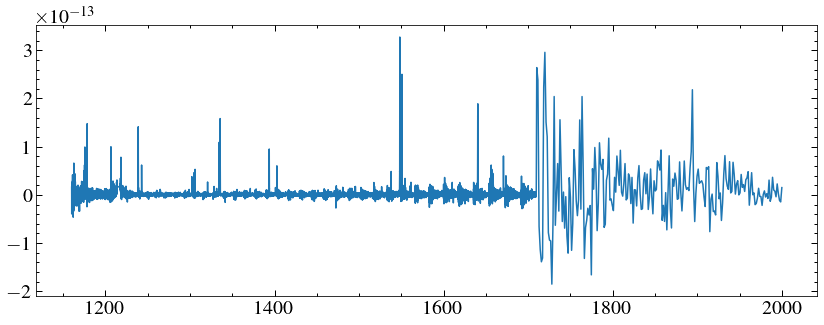

In [9]:
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])

In [10]:
line_list = Table.read('all_linelist.csv')

(1160.0, 1700.0)

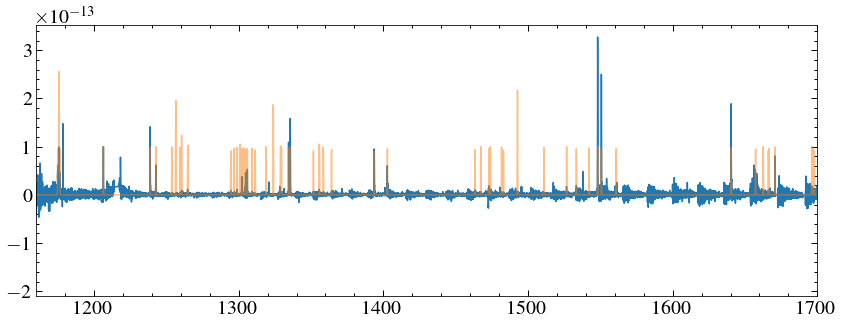

In [11]:
mod1 = models.Const1D(0)
for i in range(len(line_list)):
    amp = 1e-13
#     if line_list['Likelihood to measure'][i] == 'Low':
#         amp = amp/3
#     if line_list['Likelihood to measure'][i] == 'Medium':
#         amp = amp/2
    if line_list['Likelihood to measure'][i] in ['High', 'Medium']:
#     mod1 = mod1+ functional_models.Voigt1D(x_0=line_list['Wavelength'][i], amplitude_L=amp, fwhm_G=0.05, fwhm_L=0.05)
        mod1 = mod1 + models.Gaussian1D(amplitude=amp, mean = line_list['Wavelength'][i], stddev=0.1)


mw = np.arange(900, 1700, 0.1)
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])
plt.plot(mw, mod1(mw), alpha=0.5)
plt.xlim(1160, 1700)


In [12]:
# #50 AA chunks?
# fitter = fitting.LevMarLSQFitter()
# start = 1150
# step = 60
# w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
# # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']
# lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


# chunks = [[1205.5, 1207.5], [1235, 1245], [1262.5, 1267.5], [1290, 1300], [1323, 1325], [1332, 1338], [1350, 1352.5], [1390, 1405], 
#           [1520, 1540], 
#           [1545, 1555], [1639, 1642], [1669, 1672], [2770, 2830]]


# dv_guess = -30*u.km/u.s

# smooth =7 

# dvs = []
# dv_es = []

# for chunk in chunks:
#     start, end = chunk[0], chunk[1]
#     mask = (w >= start) & (w <= end)

#     lmask = (lines >= start) & (lines <= end)
#     if len(lines[lmask]) > 0:
#     #         plt.plot(w[mask], f[mask])
#         fi, ei = f[mask], e[mask]

#     #         mod = models.Const1D(0)
#         mod = models.Polynomial1D(2)
#         std_guess = 0.5
#         if np.median(inst[mask]) in [1, 2, 16]:
#                 std_guess = 0.1
#         if np.median(inst[mask]) in [1, 2]:
#                 fi = convolve(fi,Box1DKernel(smooth))
#                 ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
#         plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
#     #         print(std_guess)
#         for line in lines[lmask]:
#             line_guess = dv_guess.to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
# #             mod = mod+  models.Gaussian1D(amplitude=np.max(fi), mean = line_guess, stddev=std_guess)
#             mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)#, bounds=dict(amplitude_L=[0, 1]))
#             plt.axvline(line, ls='--', c='C2', alpha =0.5)
#     #             plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
#         gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=10000)
# #         print(gg_fit)
#         if type(fitter.fit_info['param_cov']) == np.ndarray:
#         #     print('hooray!')
#             fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#             mean_es = fit_e[4:][::4]
        
#     #         print(gg_fit)
#             for i in range(len(lines[lmask])):
#                 mean = gg_fit[i+1].x_0
# #                 mean = gg_fit[i+1].mean
#                 mean_e = mean_es[i]
# #                 line_e = 
#         #             obs_line = gg_fit[i+1].mean*u.AA
        
#                 dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                 eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                 edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                 dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
#                 print(dv, dve)
#                 dvs.append(dv)
#                 dv_es.append(dve)
        
        
        
#         plt.plot(w[mask], gg_fit(w[mask]))
#         plt.show()
# #     start += step
    

What about just doublets to get the rv?

In [13]:
specs = glob.glob('{}*var*'.format(path))
specs

['/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj649_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj1132_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj163_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj676a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj699_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj729_broadb

In [14]:
# lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


# chunks = [[1170, 1180], [1205.5, 1207.5], [1235, 1245], [1262.5, 1267.5], [1290, 1310], [1323, 1325], [1332, 1338], [1390, 1405],  
#           [1545, 1555], [1637, 1644], [1645, 1665], [1668, 1673], [2770, 2830]]

# for spec in specs:
#     print(spec)
#     plt.figure(figsize = (14, 5*len(chunks)))
#     data = fits.getdata(spec, 1)
#     star = fits.getheader(spec)['TARGNAME']
#     print(star)
#     #50 AA chunks?
#     w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
#     # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']



#     dv_guess = 0*u.km/u.s

#     smooth =7 

#     dvs = []
#     dv_es = []

#     for i, chunk in enumerate(chunks):
#         plt.subplot(len(chunks), 1 , i+1)
#         start, end = chunk[0], chunk[1]
#         mask = (w >= start) & (w <= end)

#         lmask = (lines >= start) & (lines <= end)
#         if len(lines[lmask]) > 0 and len(w[mask]) >0:
#         #         plt.plot(w[mask], f[mask])
#             fi, ei = f[mask], e[mask]

#         #         mod = models.Const1D(0)
#             mod = models.Polynomial1D(2)
#             std_guess = 0.5
#             if np.median(inst[mask]) in [1, 2, 16]:
#                 std_guess = 0.1
#             if np.median(inst[mask]) in [1, 2]:
#                 fi = convolve(fi,Box1DKernel(smooth))
#                 ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5

#             plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
#         #         print(std_guess)
#             for line in lines[lmask]:
#                 line_guess = dv_guess.to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
#                 mod = mod+  models.Gaussian1D(amplitude=np.max(fi), mean = line_guess, stddev=std_guess)
# #                 mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)#, bounds=dict(amplitude_L=[0, 1]))
#                 plt.axvline(line, ls='--', c='C2', alpha =0.5)
#         #             plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
#             gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=10000)
#     #         print(gg_fit)
#             if type(fitter.fit_info['param_cov']) == np.ndarray:
#             #     print('hooray!')
#                 fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#                 mean_es = fit_e[3:][1::3]

#         #         print(gg_fit)
#                 for i in range(len(lines[lmask])):
# #                     mean = gg_fit[i+1].x_0
#                     mean = gg_fit[i+1].mean
#                     mean_e = mean_es[i]
#     #                 line_e = 
#             #             obs_line = gg_fit[i+1].mean*u.AA

#                     dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                     eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                     edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
#                     dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
# #                     print(dv, dve)
#                     dvs.append(dv)
#                     dv_es.append(dve)



#             plt.plot(w[mask], gg_fit(w[mask]))
#     plt.savefig('line_plots/{}_lines.pdf'.format(star), dpi=150)
#     plt.show()
#     #     start += step


Measuring clean doublets that are detected in all stars to get velocities

GJ649
1238.821 -2.8548087743439328 km / s 0.25852727997379255 km / s
1242.804 -2.845659541354821 km / s 0.2576987389172227 km / s
1334.524 -3.4580445515142415 km / s 0.19275962164380456 km / s
1335.709 -3.4549766805986732 km / s 0.19258861122073534 km / s
1393.755 92.91009736415772 km / s 12.819989785627229 km / s
1402.77 92.31300409318766 km / s 12.737601220165374 km / s
1548.201 93.72487592378533 km / s 17.437714773497028 km / s
1550.772 93.56949095678067 km / s 17.40880506615229 km / s


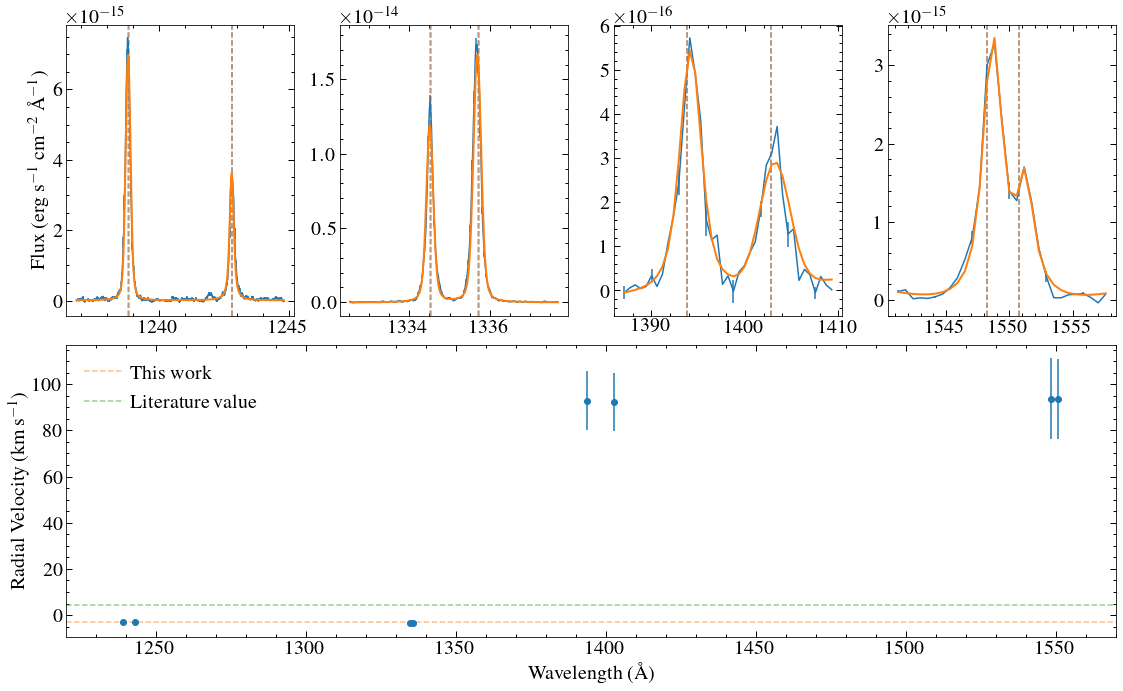

GJ1132
1238.821 33.690909209097775 km / s 1.1804851920200825 km / s
1242.804 33.58293490957493 km / s 1.1767019144325204 km / s
1334.524 45.01854856574959 km / s 1.067396093946325 km / s
1335.709 44.97860949213036 km / s 1.0664491329285966 km / s
1393.755 49.157866386855474 km / s 1.3714872707143186 km / s
1402.77 48.84194990339161 km / s 1.3626733113433183 km / s
1548.201 33.98612616571611 km / s 1.1760724889781606 km / s
1550.772 33.92978111276347 km / s 1.1741226972758447 km / s


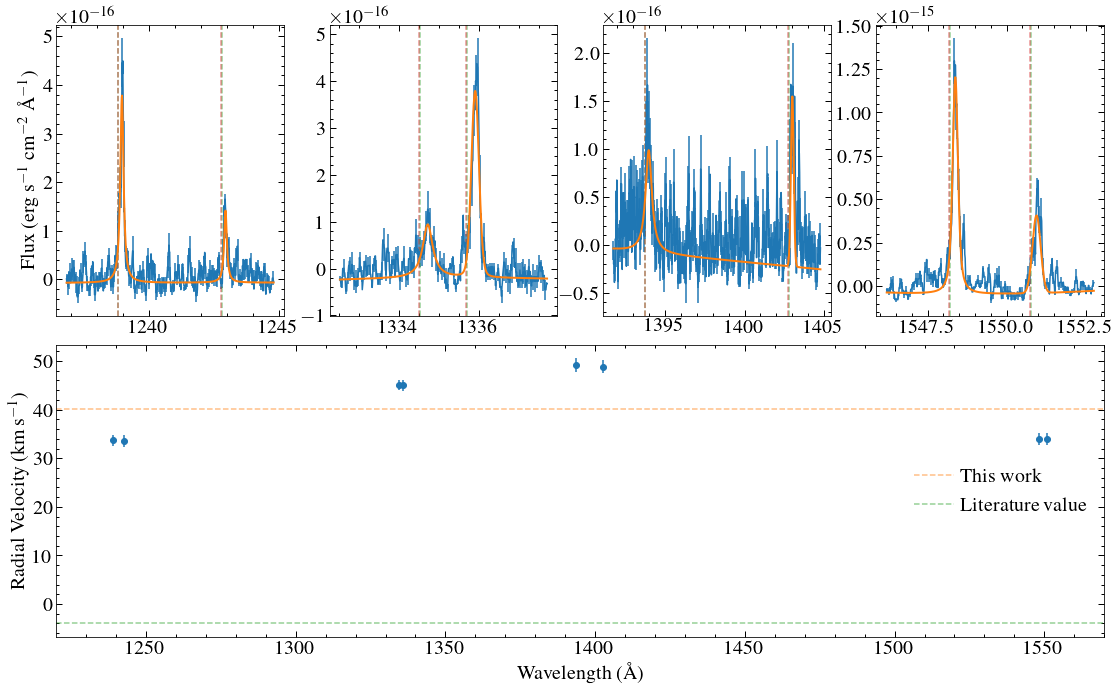

GJ15A
1238.821 -9.651284735008561 km / s 0.3943987441378072 km / s
1242.804 -9.620353818204165 km / s 0.39313475544854715 km / s
1334.524 -8.27312358357346 km / s 0.37646328847355637 km / s
1335.709 -8.265783922400816 km / s 0.376129301801019 km / s
1393.755 -3.9005650744677554 km / s 0.7216455518691383 km / s
1402.77 -3.875497818844671 km / s 0.7170078459850158 km / s


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide


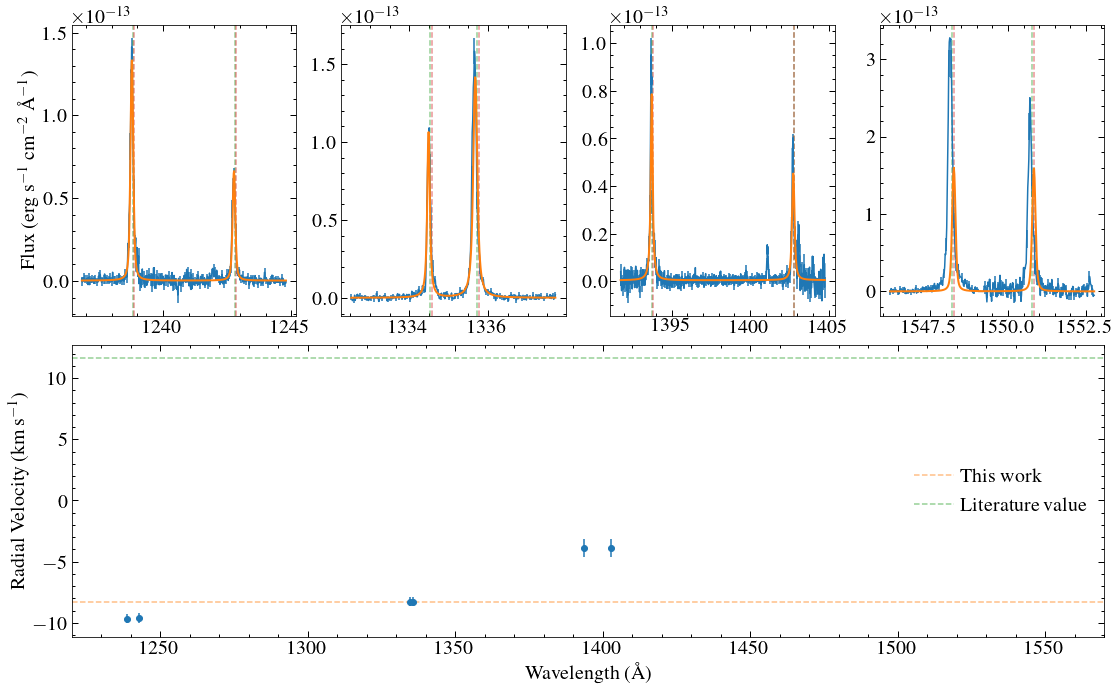

GJ163
1238.821 44.66734611930507 km / s 0.768761746826744 km / s
1242.804 44.52419398945252 km / s 0.7662979810292967 km / s
1334.524 56.2778175504559 km / s 0.4343388296964541 km / s
1335.709 56.22788959919928 km / s 0.43395349763674673 km / s
1393.755 55.665531320142215 km / s 1.3169002484831296 km / s
1402.77 55.30779287062582 km / s 1.3084370964754655 km / s
1548.201 -31.328818926693238 km / s 0.7225606488188294 km / s
1550.772 -31.276879380791055 km / s 0.7213627271076568 km / s


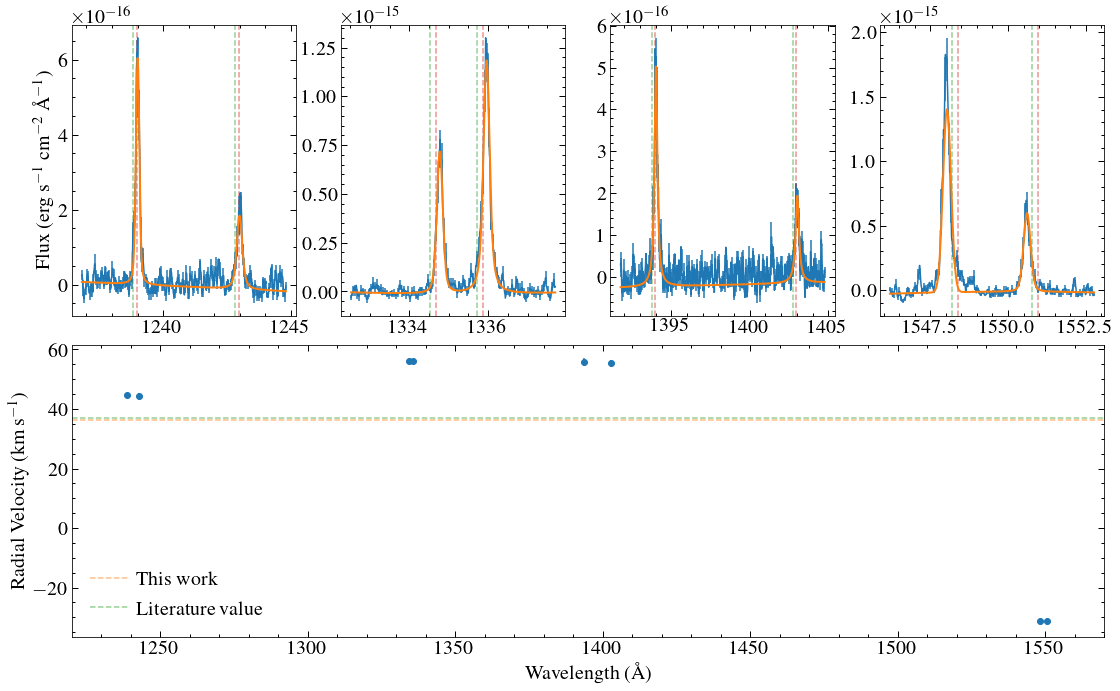

GJ674
1238.821 -6.335360792789285 km / s 0.528743929997106 km / s
1242.804 -6.315056913771197 km / s 0.5270493851733393 km / s
1334.524 -9.61649962647415 km / s 0.382170838058145 km / s
1335.709 -9.60796816333837 km / s 0.38183178782759963 km / s
1393.755 -55.042199884431334 km / s 20.56636800969104 km / s
1402.77 -54.688467318173096 km / s 20.43419680014767 km / s
1548.201 -70.22103882208174 km / s 43.834358161875464 km / s
1550.772 -70.10462048927829 km / s 43.761685883279334 km / s


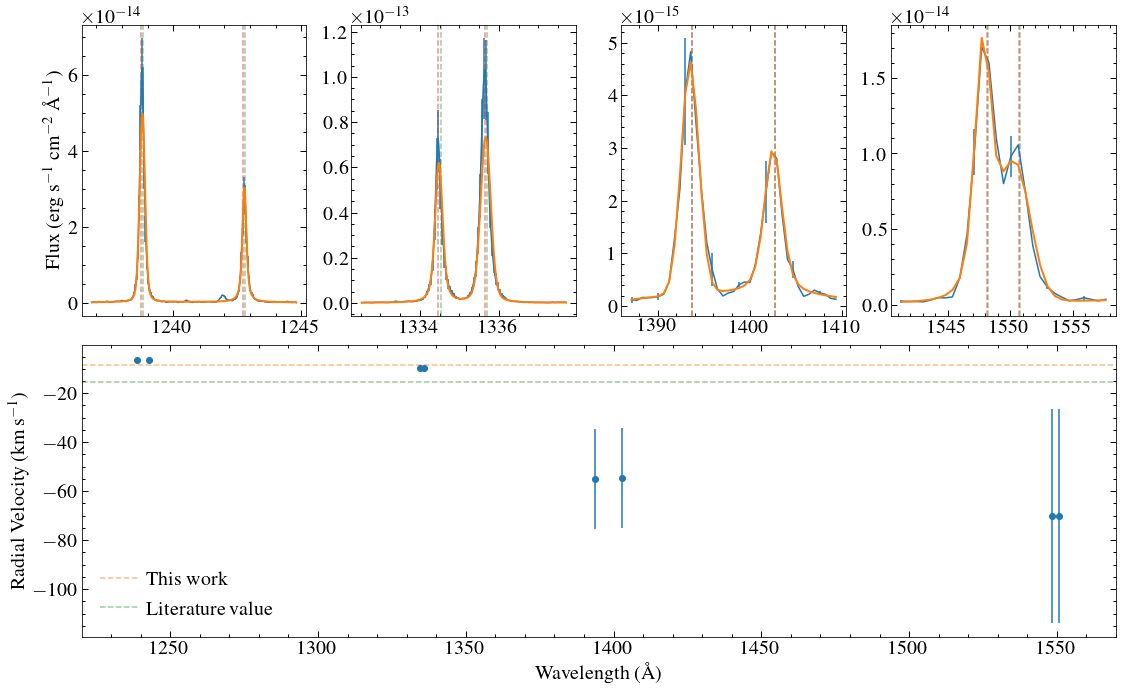

GJ676A
1238.821 -44.054788592005075 km / s 0.21452609752749296 km / s
1242.804 -43.91359961694034 km / s 0.2138385736332964 km / s
1334.524 -45.96547053536853 km / s 0.3774423093337447 km / s
1335.709 -45.92469138168433 km / s 0.3771074541077475 km / s
1393.755 -52.23651741617177 km / s 9.776581622008663 km / s
1402.77 -51.900815765512675 km / s 9.71375173305417 km / s
1548.201 -8.921362971908023 km / s 20.586036749999934 km / s
1550.772 -8.906572387449984 km / s 20.55190749017639 km / s


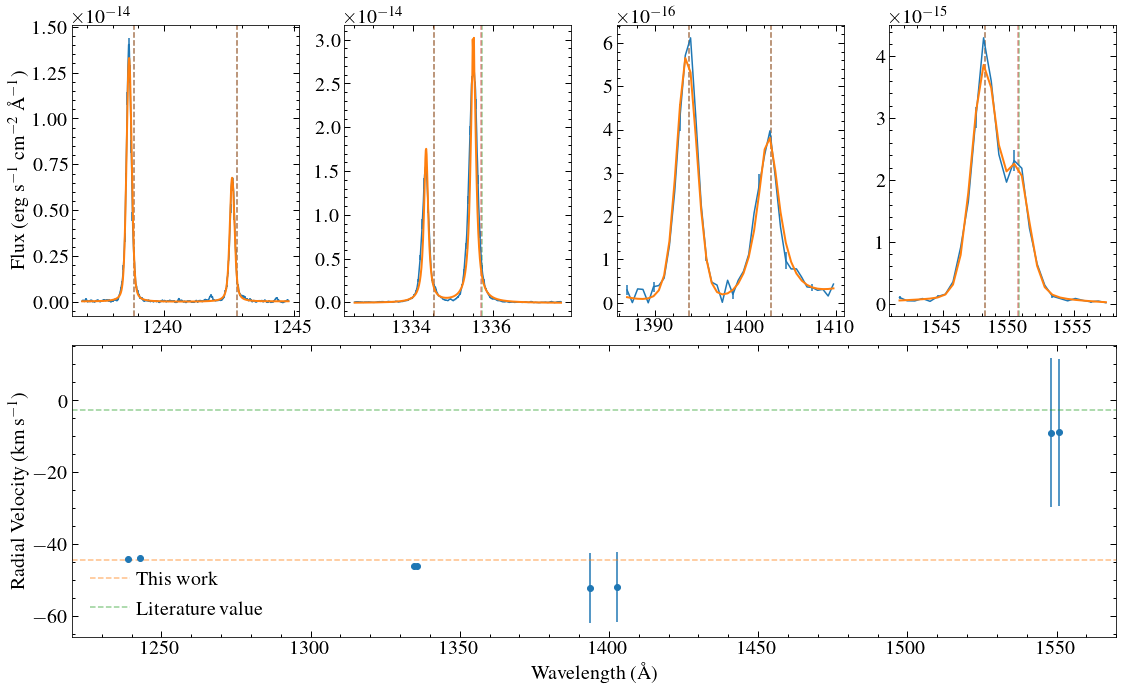

GJ699
1238.821 -131.88573921111418 km / s 0.39148263641007475 km / s
1242.804 -131.46306524218696 km / s 0.3902279934199555 km / s
1334.524 -119.20262098789776 km / s 0.33070668808890247 km / s
1335.709 -119.09686808373907 km / s 0.33041329526962215 km / s


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


1548.201 34.14871896711204 km / s 72.39411173951427 km / s
1550.772 34.09210435421345 km / s 72.27409070398562 km / s


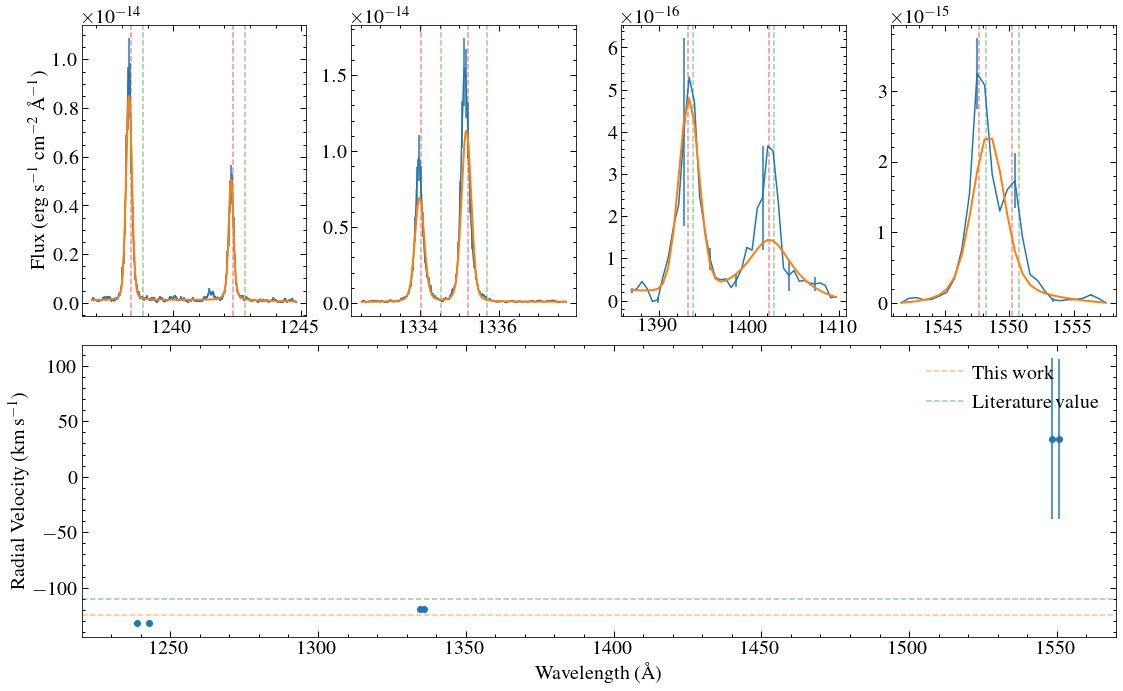

GJ729
1238.821 0.3696181210587793 km / s 4.519950413789903 km / s
1242.804 0.3684335505341995 km / s 4.505464652172238 km / s
1334.524 11.061275055709139 km / s 0.9024966489078228 km / s
1335.709 11.051461832196237 km / s 0.9016959816091843 km / s
1393.755 20.534090228726953 km / s 2.5762554412256566 km / s
1402.77 20.40212645458303 km / s 2.5596989545963353 km / s
1548.201 12.923456004350584 km / s 1.0201851721594801 km / s
1550.772 12.902030414140901 km / s 1.018493823531239 km / s


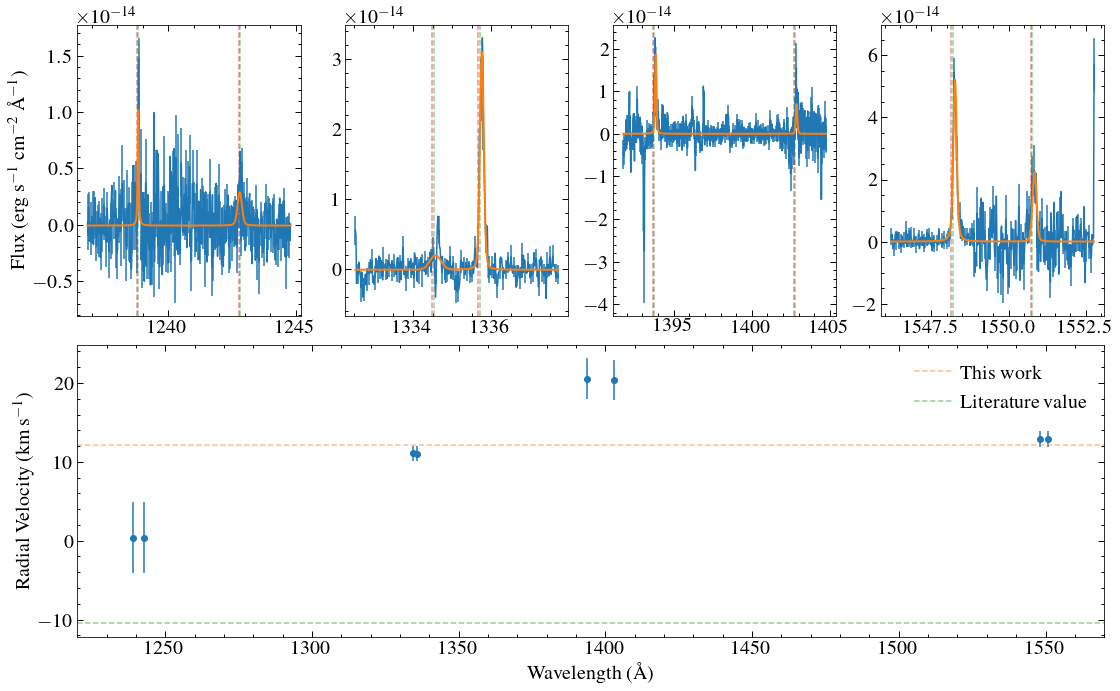

GJ849
1238.821 -25.690468239896507 km / s 0.21685460295241654 km / s
1242.804 -25.608134151014387 km / s 0.21615961654793026 km / s
1334.524 -20.372986931530527 km / s 0.17768549769120767 km / s
1335.709 -20.35491264324292 km / s 0.17752786057171832 km / s
1393.755 -15.147043014057227 km / s 0.5188616784595732 km / s
1402.77 -15.049699477493247 km / s 0.5155271774245316 km / s
1548.201 -28.824879250168834 km / s 0.3277480590518014 km / s
1550.772 -28.77709094564053 km / s 0.32720469080165415 km / s


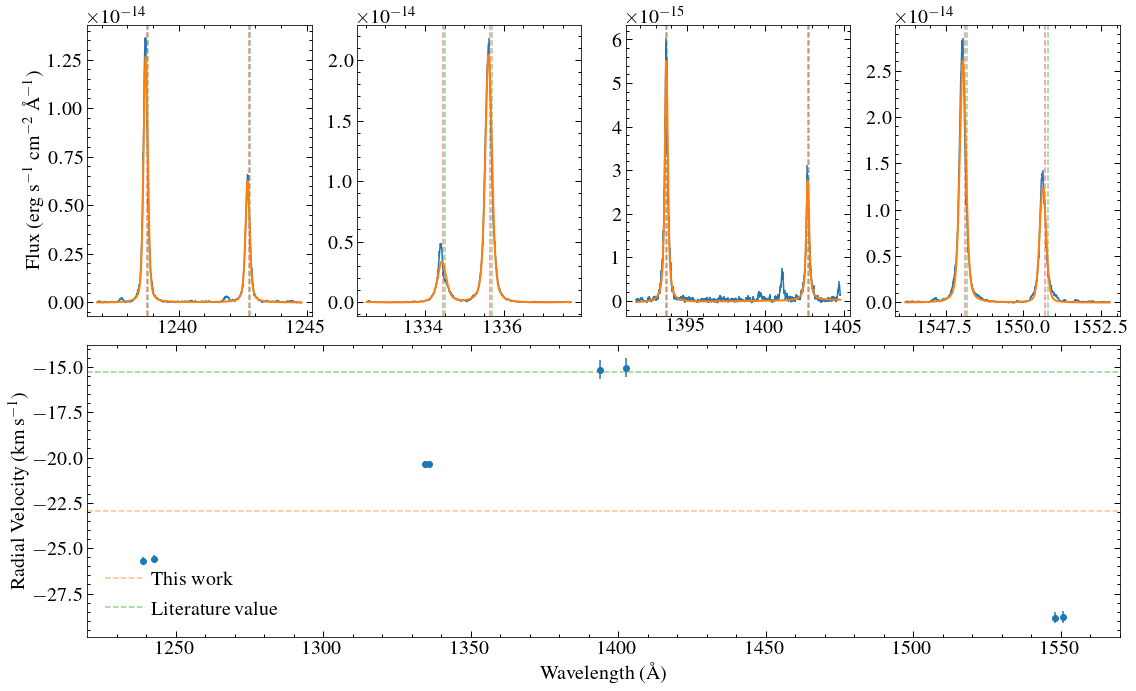

L-980-5
1238.821 -1.4139573569145827 km / s 1.0658144834557581 km / s
1242.804 -1.4094258361386103 km / s 1.0623987082599193 km / s
1334.524 19.476301311804114 km / s 0.6169348603074365 km / s
1335.709 19.459022535477473 km / s 0.6163875346314303 km / s
1393.755 27.113548649481046 km / s 1.177108563271462 km / s
1402.77 26.9393015233548 km / s 1.169543792399466 km / s
1548.201 15.178284680454796 km / s 0.8427848286524942 km / s
1550.772 15.153120846000396 km / s 0.8413875892241496 km / s


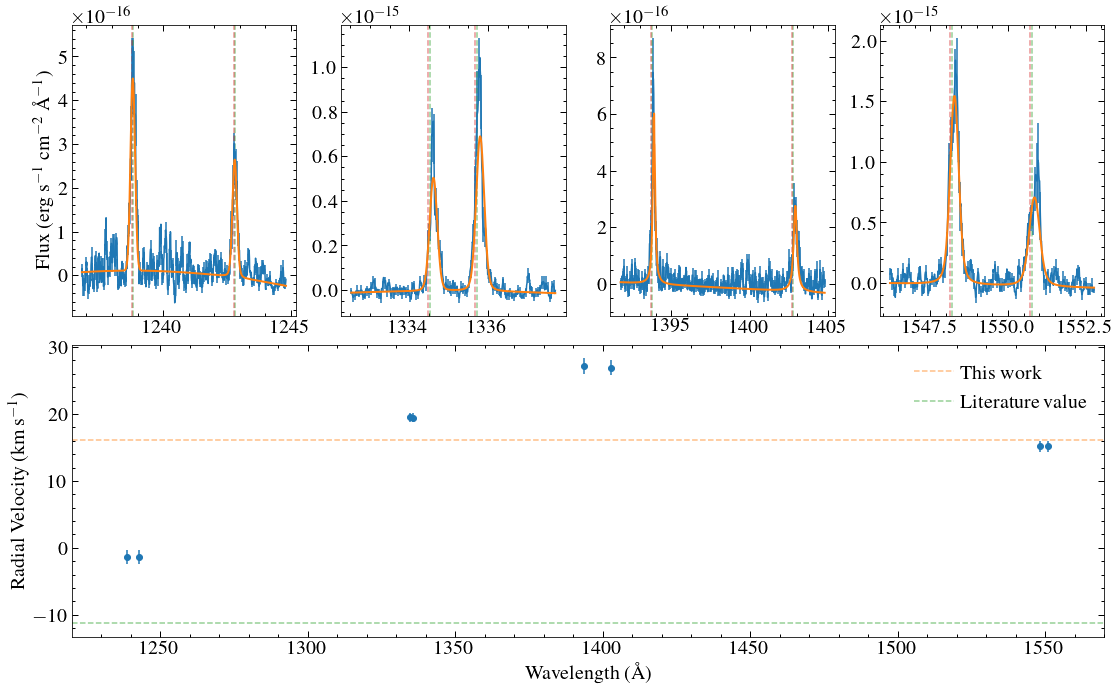

LHS-2686
1238.821 6.883921942701381 km / s 0.23666780864299897 km / s
1242.804 6.861860007666277 km / s 0.2359093238761094 km / s
1334.524 4.780443060133489 km / s 0.25735726778383006 km / s
1335.709 4.776201997873662 km / s 0.257128948342507 km / s
1393.755 -112.34323150444025 km / s 30.676408248845128 km / s
1402.77 -111.62124983101877 km / s 30.4792641551008 km / s


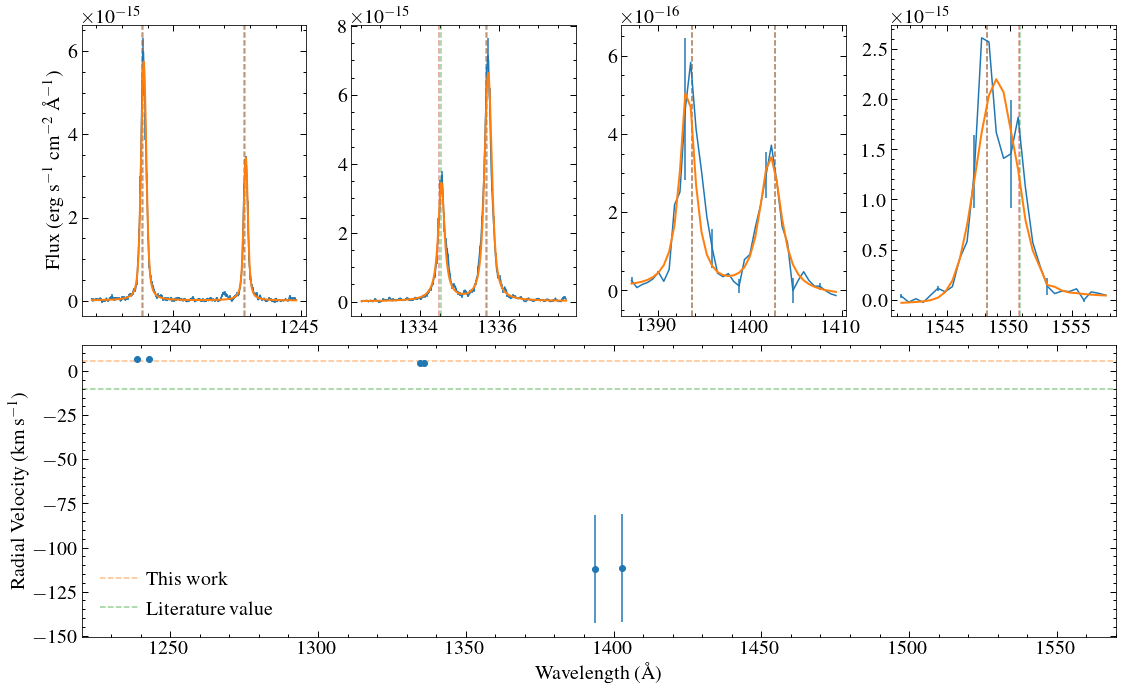

2MASS-J23062928-0502285


1334.524 -63.64135098459098 km / s 1.793211813237356 km / s
1335.709 -63.584890332666134 km / s 1.7916209307875732 km / s
1393.755 -48.7129868504015 km / s 18.048059806212823 km / s
1402.77 -48.39992941657254 km / s 17.93207268133758 km / s
1548.201 -60.395385033521556 km / s 2.7887319791466965 km / s
1550.772 -60.295256494388425 km / s 2.7841085851650575 km / s


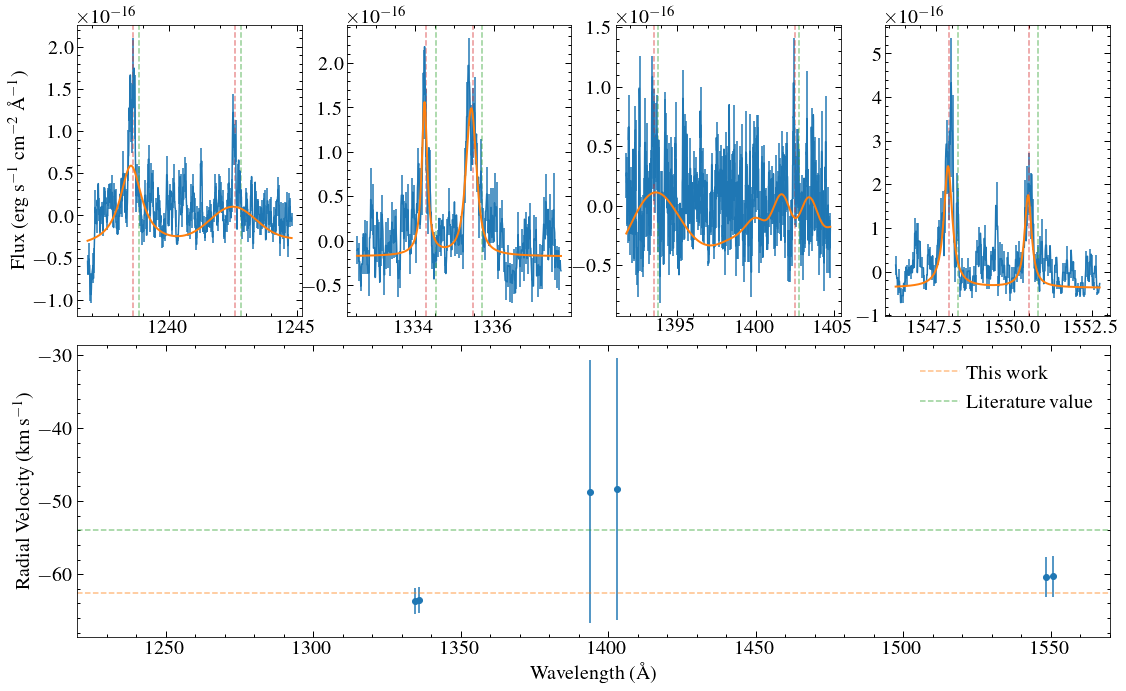

In [44]:
stars = []
final_dv = []
fitter = fitting.LevMarLSQFitter()


doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
all_lines = doublets.flatten()
names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']

# dv_guess = np.array([0, 0, -10, 0, 0, -10, -90, 10, 0, 0, 0, -50])*u.km/u.s
ref_dvs = [4.4, -4, 11.6,36.9, -15.3,-2.7, -110.5, -10.5, -15.3,-11.3, -10, -54]
dv_guess = np.array(ref_dvs)*u.km/u.s

for j, spec in enumerate(specs):
#     print(spec)
    plt.figure(figsize = (4*len(doublets), 10))
    gs = GridSpec(2, 4)
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    print(star)
    stars.append(star)
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

    smooth =7 

    dvs = []
    dv_es = []

    for i, lines in enumerate(doublets):
#         plt.subplot(1, len(doublets) , i+1)
        plt.subplot(gs[0, i])
        if i == 0:
            plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
#         start, end = lines[0]-5, lines[1]+5
        mask = (w >= lines[0]-7) & (w <= lines[1]+7)
        if np.median(inst[mask]) in [1, 2, 16]:
            mask = (w >= lines[0]-2) & (w <= lines[1]+2)
        wi, fi, ei = w[mask], f[mask], e[mask]
        mod = models.Polynomial1D(2)
        std_guess = 0.5
        if np.median(inst[mask]) in [1, 2, 16]:
            std_guess = 0.1
        if np.median(inst[mask]) in [1, 2]:
            fi = convolve(fi,Box1DKernel(smooth))
            ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
        plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
    #         print(std_guess)
        for line in lines:
            line_guess = dv_guess[j].to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
#             mod = mod+  models.Gaussian1D(amplitude=np.max(fi)/2, mean = line_guess, stddev=std_guess)
            mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)#, bounds=dict(amplitude_L=[0, 1]))
            plt.axvline(line, ls='--', c='C2', alpha =0.5)
            plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
    
        def tiedfunc0(mod):
            mean = mod.mean_1.value+np.diff(lines)
            return mean
        
        
        def tiedfunc1(mod):
            mean = mod.x_0_1.value+np.diff(lines)
            return mean
        
#         mod.mean_2.tied=tiedfunc0
        mod.x_0_2.tied=tiedfunc1
        
        gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=100000)
#         print(gg_fit)

#         if i == 3 and  np.median(inst[mask]) not in [1, 2, 16]:
#             dvs.append(0)
#             dvs.append(0)
#             dv_es.append(0)
#             dv_es.append(0)
        if type(fitter.fit_info['param_cov']) == np.ndarray:
        #     print('hooray!')
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#             print(fit_e)
#             mean_es = fit_e[4:][::4]
#             print(mean_es)
#             mean_es = fit_e[3:][1::3]

    #       print(gg_fit)
            for i in range(len(lines)):
                mean = gg_fit[i+1].x_0
#                 mean = gg_fit[i+1].mean
#                 mean_e = mean_es[i]
                mean_e = fit_e[3] #for double voights
#                 line_e = 
        #             obs_line = gg_fit[i+1].mean*u.AA

                dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
                print(lines[i], dv, dve)
                dvs.append(dv.value)
                dv_es.append(dve.value)
        else:
            dvs.append(0)
            dvs.append(0)
            dv_es.append(0)
            dv_es.append(0)
   
            
    
        plt.plot(wi, gg_fit(wi), lw=2, zorder=10)
#     plt.savefig('line_plots/{}_lines.pdf'.format(star), dpi=150)
#     plt.show()
    dvs, dv_es = np.array(dvs), np.array(dv_es)
    dv_av = np.average(dvs[dvs !=0], weights = 1/dv_es[dvs !=0]**2)
    final_dv.append(dv_av)
    plt.subplot(gs[1, :])
    plt.errorbar(all_lines[dvs !=0], dvs[dvs !=0], yerr =dv_es[dvs !=0], marker='o', ls='none')
    plt.axhline(dv_av, ls='--', c='C1', alpha=0.5, label='This work')
    plt.axhline(dv_guess[j].value, ls='--', c='C2', alpha=0.5, label='Literature value')
    plt.xlabel('Wavelength (\AA)')
    plt.ylabel('Radial Velocity (km\,s$^{-1}$)')
    plt.legend()
    plt.xlim(1220, 1570)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.1)
    plt.savefig('rv_plots/{}_rv.png'.format(star), dpi=150)
    plt.savefig('rv_plots/{}_rv.pdf'.format(star), dpi=150)
    plt.show()
    
    #     start += step


In [47]:
for s, v in zip(stars, final_dv):
    print(s,',', v)

GJ649 , -3.2179626137386097
GJ1132 , 40.08741304111106
GJ15A , -8.29172387532275
GJ163 , 36.44496578836573
GJ674 , -8.496187662426907
GJ676A , -44.461822449302915
GJ699 , -124.3703158406861
GJ729 , 12.180515773744279
GJ849 , -22.9621644919636
L-980-5 , 16.10168084165221
LHS-2686 , 5.910544014529296
2MASS-J23062928-0502285 , -62.558323075720324
